In [1]:
import time
import cv2
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
from tsdf import TSDF, get_volume_bounds

PyCUDA successfully imported. Running in GPU mode.


## Data Processing

In [5]:
data_folder = "data/suzanne/"
cam_intrinsics_file = data_folder + "cam.txt"
frame_color_img_file = data_folder + "rgb_{:04d}.png"
frame_depth_img_file = data_folder + "depth_{:04d}.exr"
frame_pose_file = data_folder + "pose_{:04d}.txt"
frames_count = 240
cam_to_motion_T = np.diag([1, 1, 1, 1])
output_mesh_file = "suzanne_outputs/suzanne_mesh.ply"
output_pc_file = "suzanne_outputs/suzanne_pc.ply"

In [6]:
def process_data():
    frame_color_imgs = []
    frame_depth_imgs = []
    frame_poses = []

    # read the data
    for i in range(frames_count):
        color_img = cv2.imread(frame_color_img_file.format(i))
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
        # flip image horizontally
        color_img = cv2.flip(color_img, 1)
        frame_color_imgs.append(color_img)

        depth_img = cv2.imread(frame_depth_img_file.format(i), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
        depth_img = cv2.flip(depth_img, 1)
        depth_img[depth_img == 65504] = 0
        
        frame_depth_imgs.append(depth_img)
        frame_pose = np.loadtxt(frame_pose_file.format(i)) @ cam_to_motion_T
        frame_poses.append(frame_pose)
    return frame_color_imgs, frame_depth_imgs, frame_poses


In [7]:
frame_color_imgs, frame_depth_imgs, frame_poses = process_data()
cam_intrinsics = np.loadtxt(cam_intrinsics_file)

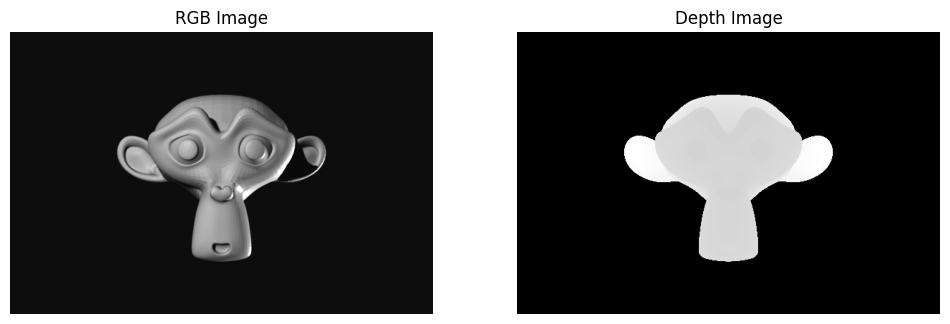

In [8]:
rgb_img = frame_color_imgs[0]
depth_img = frame_depth_imgs[0]
p = frame_poses[0]

import matplotlib.pyplot as plt
# plot the first frame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("RGB Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(depth_img, cmap="gray")
plt.title("Depth Image")
plt.axis("off")
plt.show()

## TSDF Construction

In [13]:
tsdf_voxel_size = 0.04  # 2cm
tsdf_trunc_margin =5*tsdf_voxel_size  # 10cm

volume_bounds = get_volume_bounds(
    frames_count, frame_depth_imgs, frame_poses, cam_intrinsics
)

Volume bounds:
[[-6.99956322  6.99956322]
 [-6.99997425  6.99917221]
 [-7.00000191  7.00000191]]


In [14]:
tsdf_obj = TSDF(
    volume_bounds,
    voxel_size=tsdf_voxel_size,
    trunc_margin=tsdf_trunc_margin,
    run_on_gpu=True,
)
start_time = time.time()
tsdf_obj.build_tsdf(
    frames_count, frame_color_imgs, frame_depth_imgs, frame_poses, cam_intrinsics
)
end_time = time.time()
print("Time: ", end_time - start_time, "seconds")
print("FPS: ", frames_count / (end_time - start_time))

Volume dims:  [350 350 351]


Using GPU:  NVIDIA GeForce RTX 3090
Maximum number of threads per block: 1024
Maximum block dimension: 1024, 1024, 64
Maximum grid dimension: 2147483647, 65535, 65535
Block size: (1024, 1, 1), Grid size: (41990, 1, 1)
Fusing frame 0
Fusing frame 1
Fusing frame 2
Fusing frame 3
Fusing frame 4
Fusing frame 5
Fusing frame 6
Fusing frame 7
Fusing frame 8
Fusing frame 9
Fusing frame 10
Fusing frame 11
Fusing frame 12
Fusing frame 13
Fusing frame 14
Fusing frame 15
Fusing frame 16
Fusing frame 17
Fusing frame 18
Fusing frame 19
Fusing frame 20
Fusing frame 21
Fusing frame 22
Fusing frame 23
Fusing frame 24
Fusing frame 25
Fusing frame 26
Fusing frame 27
Fusing frame 28
Fusing frame 29
Fusing frame 30
Fusing frame 31
Fusing frame 32
Fusing frame 33
Fusing frame 34
Fusing frame 35
Fusing frame 36
Fusing frame 37
Fusing frame 38
Fusing frame 39
Fusing frame 40
Fusing frame 41
Fusing frame 42
Fusing frame 43
Fusing frame 44
Fusing frame 45
Fusing frame 46
Fusing frame 47
Fusing frame 48
Fusing f

In [15]:
tsdf_obj.save_mesh(output_mesh_file)
tsdf_obj.save_point_cloud(output_pc_file)

Mesh saved to suzanne_outputs/suzanne_mesh.ply
Point cloud saved to suzanne_outputs/suzanne_pc.ply


## Visualizations

### Dataset

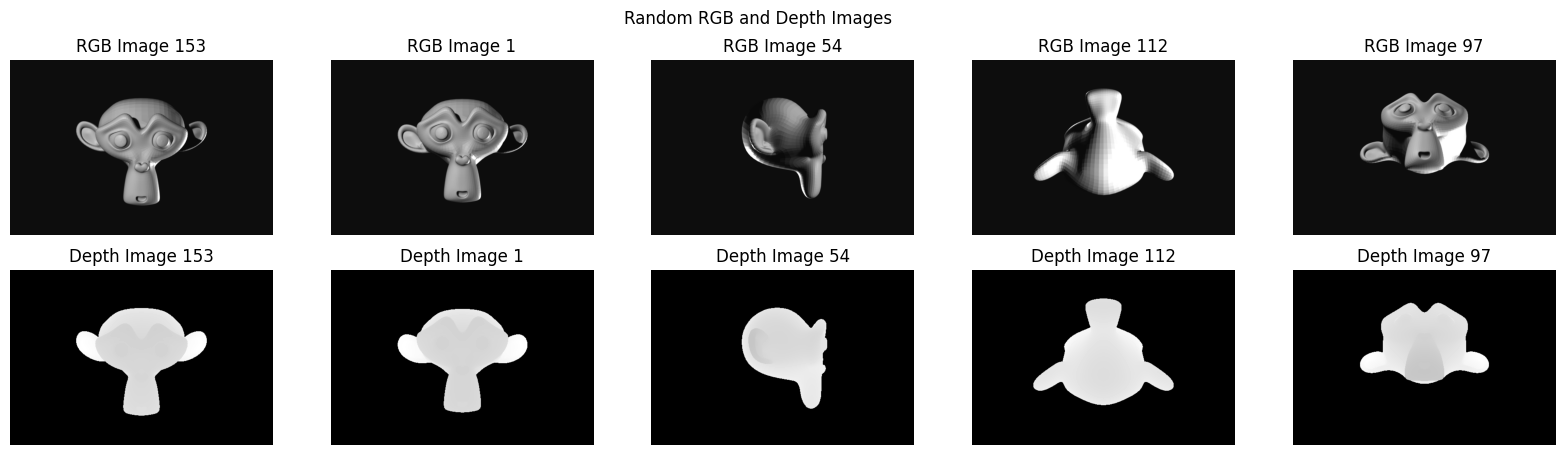

In [16]:
# show random dataset rgb images and depth images in one figure
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    idx = np.random.randint(frames_count)
    axs[0, i].imshow(frame_color_imgs[idx])
    axs[0, i].set_title(f"RGB Image {idx}")
    axs[0, i].axis("off")
    axs[1, i].imshow(frame_depth_imgs[idx], cmap="gray")
    axs[1, i].set_title(f"Depth Image {idx}")
    axs[1, i].axis("off")
plt.suptitle("Random RGB and Depth Images")
plt.show()


### Occupancy Dual Contouring

In [17]:
import torch

volume_origin = torch.tensor(tsdf_obj.volume_origin, device="cuda:0")
tsdf_tensor = torch.tensor(tsdf_obj.get_tsdf()[0], device="cuda:0")
voxel_size = tsdf_obj.voxel_size


def implicit_function(xyz):
    """
    Implicit function for the TSDF volume. Performs trilinear interpolation to get the value at the given point.
    """
    # world space to voxel grid space
    relative_xyz = (xyz - volume_origin) / voxel_size

    device = relative_xyz.device
    min_bound = torch.tensor([0, 0, 0], dtype=torch.float64, device=device)
    max_bound = torch.tensor([tsdf_tensor.shape[0] - 1, 
                              tsdf_tensor.shape[1] - 1, 
                              tsdf_tensor.shape[2] - 1], dtype=torch.float64, device=device)
    relative_xyz = torch.clamp(relative_xyz, min=min_bound, max=max_bound)
    

    interpolated_values = []
    
    # interpolation for each point in xyz
    for i in range(xyz.shape[0]):
        xyz_point = relative_xyz[i]
        lower_indices = torch.floor(xyz_point).long()
        fractional_part = xyz_point - lower_indices.float()

        # neighbors - 8 surrounding points for trilinear interpolation
        x0, y0, z0 = lower_indices
        x1, y1, z1 = x0 + 1, y0 + 1, z0 + 1

        # Fetch the values at the 8 surrounding points 
        values = []
        for j, k, l in [(x0, y0, z0), (x0, y0, z1), (x0, y1, z0), (x0, y1, z1),
                         (x1, y0, z0), (x1, y0, z1), (x1, y1, z0), (x1, y1, z1)]:
            if 0 <= j < tsdf_tensor.shape[0] and 0 <= k < tsdf_tensor.shape[1] and 0 <= l < tsdf_tensor.shape[2]:
                values.append(tsdf_tensor[j, k, l])
            else:
                values.append(torch.tensor(0.0, dtype=torch.float64)) 
                
        c000, c001, c010, c011, c100, c101, c110, c111 = values
        c00 = c000 * (1 - fractional_part[0]) + c100 * fractional_part[0]
        c01 = c001 * (1 - fractional_part[0]) + c101 * fractional_part[0]
        c10 = c010 * (1 - fractional_part[0]) + c110 * fractional_part[0]
        c11 = c011 * (1 - fractional_part[0]) + c111 * fractional_part[0]
        c0 = c00 * (1 - fractional_part[1]) + c10 * fractional_part[1]
        c1 = c01 * (1 - fractional_part[1]) + c11 * fractional_part[1]
        interpolated_value = c0 * (1 - fractional_part[2]) + c1 * fractional_part[2]
        
        interpolated_values.append(interpolated_value)
    
    return torch.stack(interpolated_values)


from occupancy_dual_contouring import occupancy_dual_contouring
odc = occupancy_dual_contouring("cuda:0")
vertices, triangles = odc.extract_mesh(implicit_function, min_coord=tsdf_obj.volume_bounds[:,0].flatten(), max_coord=tsdf_obj.volume_bounds[:,1].flatten(), num_grid=100)


In [18]:
import trimesh
mesh = trimesh.Trimesh(vertices.cpu().numpy(), triangles.cpu().numpy())
mesh.export("suzanne_outputs/suzanne_odc.ply")
print("ODC Mesh exported")

ODC Mesh exported


### TSDF update

In [ ]:
tsdf_obj_ = TSDF(
    volume_bounds,
    voxel_size=tsdf_voxel_size,
    trunc_margin=tsdf_trunc_margin,
    run_on_gpu=True,
    verbose=False
)
for i in range(frames_count):
    tsdf_obj_.add_frame(
        frame_color_imgs[i], frame_depth_imgs[i], frame_poses[i], cam_intrinsics
    )
    if i in [1, 10, 50, 100, 200, 500]:
        tsdf_obj_.save_mesh(f"suzanne_outputs/tsdf_update/suzanne_mesh_{i}.ply")

### Different hyperparameters

In [ ]:
# changing the voxel size
voxel_sizes = [0.01, 0.02, 0.5]
for v in voxel_sizes:
    tsdf_obj_ = TSDF(
        volume_bounds,
        voxel_size=v,
        trunc_margin=tsdf_trunc_margin,
        run_on_gpu=True,
        verbose=False
    )
    start_time = time.time()
    tsdf_obj_.build_tsdf(
        frames_count, frame_color_imgs, frame_depth_imgs, frame_poses, cam_intrinsics
    )
    end_time = time.time()
    print("Time: ", end_time - start_time, "seconds for voxel size: ", v)
    tsdf_obj_.save_mesh(f"suzanne_outputs/hyperparameters/voxel_size_{voxel_size}.ply")

In [ ]:
# changing the truncation margin
trunc_margins = [0.01, 0.1, 0.5]
for t in trunc_margins:
    tsdf_obj_ = TSDF(
        volume_bounds,
        voxel_size=tsdf_voxel_size,
        trunc_margin=t,
        run_on_gpu=True,
        verbose=False
    )
    start_time = time.time()
    tsdf_obj_.build_tsdf(
        frames_count, frame_color_imgs, frame_depth_imgs, frame_poses, cam_intrinsics
    )
    end_time = time.time()
    print("Time: ", end_time - start_time, "seconds for truncation margin: ", t)
    tsdf_obj_.save_mesh(f"bunny_outputs/hyperparameters/trunc_margin_{t}.ply")

## Nearest Pose Estimation

Creating the tsdf only on every 5th frame and then using the nearest pose estimation to get the tsdf for the intermediate frames.

In [22]:
train_frame_count = frames_count // 5
train_frame_color_imgs = frame_color_imgs[::5]
train_frame_depth_imgs = frame_depth_imgs[::5]
train_frame_poses = frame_poses[::5]

In [23]:
tsdf_obj_ = TSDF(
    volume_bounds,
    voxel_size=tsdf_voxel_size,
    trunc_margin=tsdf_trunc_margin,
    run_on_gpu=True,
)
start_time = time.time()
tsdf_obj_.build_tsdf(
    train_frame_count, train_frame_color_imgs, train_frame_depth_imgs, train_frame_poses, cam_intrinsics
)
end_time = time.time()
print("Time: ", end_time - start_time, "seconds")
print("FPS: ", frames_count / (end_time - start_time))

Volume dims:  [350 350 351]
Using GPU:  NVIDIA GeForce RTX 3090
Maximum number of threads per block: 1024
Maximum block dimension: 1024, 1024, 64
Maximum grid dimension: 2147483647, 65535, 65535
Block size: (1024, 1, 1), Grid size: (41990, 1, 1)
Fusing frame 0
Fusing frame 1
Fusing frame 2
Fusing frame 3
Fusing frame 4
Fusing frame 5
Fusing frame 6
Fusing frame 7
Fusing frame 8
Fusing frame 9
Fusing frame 10
Fusing frame 11
Fusing frame 12
Fusing frame 13
Fusing frame 14
Fusing frame 15
Fusing frame 16
Fusing frame 17
Fusing frame 18
Fusing frame 19
Fusing frame 20
Fusing frame 21
Fusing frame 22
Fusing frame 23
Fusing frame 24
Fusing frame 25
Fusing frame 26
Fusing frame 27
Fusing frame 28
Fusing frame 29
Fusing frame 30
Fusing frame 31
Fusing frame 32
Fusing frame 33
Fusing frame 34
Fusing frame 35
Fusing frame 36
Fusing frame 37
Fusing frame 38
Fusing frame 39
Fusing frame 40
Fusing frame 41
Fusing frame 42
Fusing frame 43
Fusing frame 44
Fusing frame 45
Fusing frame 46
Fusing frame

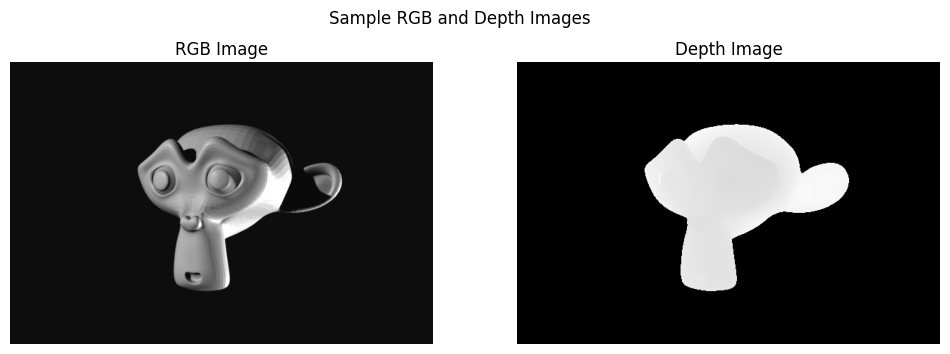

In [24]:
# randomly sampling a image
sample_image_rgb = frame_color_imgs[13]
sample_image_depth = frame_depth_imgs[13]
true_pose = frame_poses[13]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_rgb)
plt.title("RGB Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sample_image_depth, cmap="gray")
plt.title("Depth Image")
plt.axis("off")
plt.suptitle("Sample RGB and Depth Images")
plt.show()

In [25]:
# alignment loss
def compute_alignment_loss(fixed_tsdf, moving_tsdf):
    mask = moving_tsdf != 1
    fixed_tsdf = fixed_tsdf[mask]
    moving_tsdf = moving_tsdf[mask]
    alignment_loss = np.sum(np.abs(fixed_tsdf - moving_tsdf))
    return alignment_loss

In [26]:
tsdf_grid, _, _ = tsdf_obj_.get_tsdf()

In [27]:
# iterate over all frames and find the best pose
min_loss = np.inf
best_pose = np.eye(4, 4)
min_index = 0
index = 0
for pose in train_frame_poses:
    tsdf_obj_sample_image = TSDF(
        volume_bounds,
        voxel_size=tsdf_voxel_size,
        trunc_margin=tsdf_trunc_margin,
        run_on_gpu=True,
        verbose=False
    )
    tsdf_obj_sample_image.build_tsdf(
        1, [sample_image_rgb], [sample_image_depth], [pose], cam_intrinsics
    )
    
    tsdf_grid_sample_image, _, color_grid_sample_image = tsdf_obj_sample_image.get_tsdf()
    
    loss = compute_alignment_loss(tsdf_grid, tsdf_grid_sample_image)
    
    if loss < min_loss:
        min_loss = loss
        min_pose = pose
        min_index = index
    
    index += 1


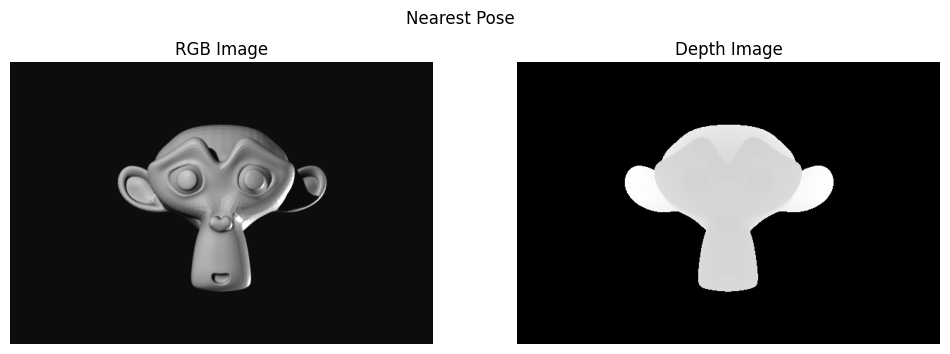

In [28]:
# show the nearest pose
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(frame_color_imgs[min_index])
# plt.imshow(cv2.flip(frame_color_imgs[min_index], 1))
plt.title("RGB Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(frame_depth_imgs[min_index], cmap="gray")
# plt.imshow(cv2.flip(frame_depth_imgs[min_index], 1), cmap="gray")
plt.title("Depth Image")
plt.axis("off")
plt.suptitle("Nearest Pose")
plt.show()

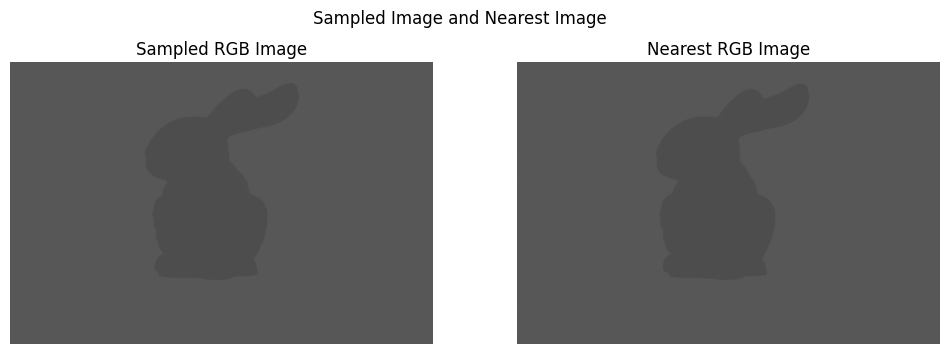

In [42]:
# show true image and the nearest image
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_rgb)
plt.title("Sampled RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(frame_color_imgs[min_index])
plt.title("Nearest RGB Image")
plt.axis("off")
plt.suptitle("Sampled Image and Nearest Image")
plt.show()

In [29]:
print("True Pose:")
print(true_pose)
print("Estimated Pose:")
print(frame_poses[min_index])
print("Loss:", min_loss)

True Pose:
[[-0.90311646  0.          0.42939562 -3.00577116]
 [ 0.         -1.          0.          0.        ]
 [-0.42939562  0.         -0.90311646  6.32181644]
 [ 0.          0.          0.          1.        ]]
Estimated Pose:
[[-0.99993289  0.          0.01158436 -0.08109171]
 [ 0.         -1.          0.          0.        ]
 [-0.01158436  0.         -0.99993289  6.99953222]
 [ 0.          0.          0.          1.        ]]
Loss: 4327.721
